<a href="https://colab.research.google.com/github/mbcruz96/Neural-Network/blob/main/Binary_Classification_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install torch
import torch
import matplotlib.pyplot as plt
import numpy as np

#Model Architecture

In [8]:
"""
Michael Cruz
"""


from __future__ import division
from __future__ import print_function

import sys
try:
   import _pickle as pickle
except:
   import pickle

import numpy as np
import math
# This is a class for a LinearTransform layer which takes an input
# weight matrix W and computes W x as the forward step
class LinearTransform(object):

    def __init__(self, W, b):
	# DEFINE __init function
        self.W = W
        self.b = b

    def update_parameters(self, update_w, update_b, learning_rate=0.0):
        self.W = self.W - learning_rate * update_w
        self.b = self.b - learning_rate * update_b
        return(self.W, self.b)

    def forward(self, x):
	# DEFINE forward function
        a = self.b + (self.W @ x)
        return a

    def backward(
        self,
        grad_output,
        batch_size,
        learning_rate=0.0,
        momentum=0.0,
        l2_penalty=0.0,
    ):
      w_grad = np.matmul(grad_output[0], grad_output[1])/batch_size
      w_grad = w_grad + l2_penalty * self.W
      #b_grad = np.multiply(grad_output[0] , self.b)
      b_grad = np.sum(grad_output[0], axis=1, keepdims=True)/batch_size
      b_grad = b_grad + l2_penalty * self.b
      #b_grad = b_grad + l2_penalty * self.b
      return w_grad, b_grad
	# DEFINE backward function
# ADD other operations in LinearTransform if needed



In [31]:

# This is a class for a ReLU layer max(x,0)
class ReLU(object):
    def __init__(self):
        self.rel = np.vectorize(self.relu)
        self.rel_deriv = np.vectorize(self.relu_derivative)
        self.a = 0

    # ReLU activation function
    def relu(self, x):
        return max(0, x)

    # ReLU derivative
    def relu_derivative(self, x):
        if x > 0:
            return 1
        else:
            return 0

    def forward(self, x):
	# DEFINE forward function
        self.z = x
        self.a = self.rel(x)
        return self.a

    def backward(
        self,
        grad_output,
        learning_rate=0.0,
        momentum=0.0,
        l2_penalty=0.0,
    ):
      # DEFINE backward function
      deriv = self.rel_deriv(self.z)
      #print(f'rel deriv: {deriv.shape}')
      #print(f'grad output: {type(grad_output)}')
      z1_grad = np.multiply(grad_output, deriv)
      return z1_grad

# ADD other operations in ReLU if needed


In [3]:

# This is a class for a sigmoid layer followed by a cross entropy loss function, the reason
# this is put into a single layer is because it has a simple gradient form
class SigmoidCrossEntropy(object):
    def __init__(self, hidden_dim):
        self.y_hat = np.zeros((1, hidden_dim))   # final output matrix for backpropogation
        self.z2 = 0
        self.loss = 0.0
        self.sig = np.vectorize(self.sigmoid)
        self.sig_deriv = np.vectorize(self.sigmoid_derivative)
        self.ce_derivative = np.vectorize(self.cross_entropy_derivative)

    # Sigmoid activation function
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    # Sigmoid derivative
    def sigmoid_derivative(self, x):
        return x * (1 - x)

    # Cross entropy loss function
    def cross_entropy(self, y_hat, y_true):
        ep = 1e-15
        loss = 0
        y_hat = np.clip(y_hat, ep, 1 - ep)
        y_true = y_true.transpose()
        loss = -np.mean(y_true * np.log(y_hat) + (1 - y_true) * np.log(1 - y_hat))
        return loss

    # Cross entropy derivative
    def cross_entropy_derivative(self, y_hat, y_true):
        deriv = []  # derivative of each sample
        for i in range(y_hat.shape[1]):
          den = y_hat[0, i] * (1 - y_hat[0, i]) # denominator term
          if  y_hat[0, i] == 0:
            derivative =  (1 - y_true[i, 0]) / (1 - y_hat[0, i])
          else:
            derivative = -1*(y_true[i, 0] / y_hat[0, i])
          deriv.append(derivative)
        deriv = np.array(deriv)
        return deriv

    def layer_output_derivative(self, y_hat, y_true):
      return np.subtract(y_hat, np.transpose(y_true))

    # L2 regularization across parameters
    def regularization(self, W1, b1, W2, b2):
        layer_W1 = np.sum((W1) ** 2)
        layer_b1 = np.sum((b1) ** 2)
        layer_W2 = np.sum((W2) ** 2)
        layer_b2 = np.sum((b2) ** 2)
        loss = layer_W1 + layer_b1 + layer_W2 + layer_b2
        return loss


    def forward(self, x, y, W1, b1, W2, b2, l2_penalty=0.0):
        # DEFINE forward function
        self.a2 = self.sigmoid(x)
        self.reg = (l2_penalty/2)*self.regularization(W1, b1, W2, b2)
        self.loss = self.cross_entropy(self.a2, y) + (l2_penalty/2)*self.reg
        return (self.a2, self.loss)

    def backward(
	    self,
      y,
	    grad_output,
		  learning_rate=0.0,
		  momentum=0.0,
		  l2_penalty=0.0
	):
		  # DEFINE backward function
      z2_grad = -(np.transpose(y) - self.a2)
      #print(f'z2 grad: {z2_grad.shape}')
      return z2_grad

# ADD other operations and data entries in SigmoidCrossEntropy if needed


In [32]:
# This is a class for the Neural Network
class Net(object):

    def __init__(self, input_dims, hidden_units):
    # INSERT CODE for initializing the network
        np.random.seed(17)
        self.hidden_bias = np.zeros((hidden_units, 1))
        self.output_bias = 0.0
        self.hidden_layer = 0.1*np.random.rand(hidden_units, input_dims) # (hidden dims, input dims)
        self.output_layer = 0.1*np.random.rand(1, hidden_units)  # (neurons, hidden dims)

        self.linear1 = LinearTransform(self.hidden_layer, self.hidden_bias)
        self.linear2 = LinearTransform(self.output_layer, self.output_bias)

        self.grad_table = {
            'W1': 0,
            'b1': 0,
            'W2': 0,
            'b2': 0,
            'z1': 0,
            'a1': 0,
            'z2': 0,
            'J' : 1.0
        }
        self.relu = ReLU()
        self.sigmoid_ce = SigmoidCrossEntropy(hidden_units)
        self.out = np.vectorize(self.output)

    # constructs output vector
    def output(self, y_hat):
      if y_hat >= 0.5:
        return 1
      else:
        return 0

    def train(
        self,
        x_batch,
        y_batch,
        batch_size,
        learning_rate,
        momentum,
        l2_penalty,
    ):
	# INSERT CODE for training the network

        # forward pass
        z1 = self.linear1.forward(np.transpose(x_batch))
        a1 = self.relu.forward(z1)
        z2 = self.linear2.forward(a1)
        a2, loss = self.sigmoid_ce.forward(z2, y_batch, self.hidden_layer, self.hidden_bias, self.output_layer, self.output_bias, l2_penalty)

        # backward pass
        self.grad_table['z2']= self.sigmoid_ce.backward(y_batch, self.grad_table['J'], learning_rate, momentum, l2_penalty)

        # output layer weights and bias updates
        grad_output = [self.grad_table['z2'], np.transpose(a1)]
        self.grad_table['W2'], self.grad_table['b2'] = self.linear2.backward(grad_output, batch_size)
        self.grad_table['a1'] = np.transpose(self.output_layer)@self.grad_table['z2']
        self.grad_table['z1'] = self.relu.backward(self.grad_table['a1'])

        grad_output = [self.grad_table['z1'], x_batch]
        self.grad_table['W1'], self.grad_table['b1'] = self.linear1.backward(grad_output, batch_size)
        self.grad_table['b1'] = self.grad_table['b1'].reshape(self.grad_table['b1'].shape[0], -1)

        self.hidden_layer, self.hidden_bias = self.linear1.update_parameters(self.grad_table['W1'], self.grad_table['b1'], learning_rate)
        self.output_layer, self.output_bias = self.linear2.update_parameters(self.grad_table['W2'], self.grad_table['b2'], learning_rate)

        output = self.out(a2)
        return loss, output

    def evaluate(self, x, y):
	# INSERT CODE for testing the network
        # forward pass
        a1 = self.linear1.forward(np.transpose(x))
        z1 = self.relu.forward(a1)
        a2 = self.linear2.forward(z1)
        y_hat, loss = self.sigmoid_ce.forward(a2, y, self.hidden_layer, self.hidden_bias, self.output_layer, self.output_bias, l2_penalty)
        output = self.out(a2)
        return loss, output
# ADD other operations and data entries if needed



#Retrieving dataset

In [6]:
if sys.version_info[0] < 3:
    data = pickle.load(open('cifar_2class_py2.p', 'rb'))
    train_x = data['train_data']
    train_y = data['train_labels']
    test_x = data['test_data']
    test_y = data['test_labels']
else:
    data = pickle.load(open('cifar_2class_py2.p', 'rb'), encoding='bytes')
    train_x = data[b'train_data']
    train_y = data[b'train_labels']
    test_x = data[b'test_data']
    test_y = data[b'test_labels']

num_examples, input_dims = train_x.shape
test_num_examples, test_dims = test_x.shape

#Training

In [74]:
# INSERT YOUR CODE HERE
# YOU CAN CHANGE num_epochs AND num_batches TO YOUR DESIRED VALUES
num_epochs = 50
num_batches = 1000
hidden_units = 15
batch_size = 200
learning_rate = 0.001
momentum = 0.9
l2_penalty = 0.0001
train_index = batch_size
test_index = batch_size

total_train_losses = []
total_train_error = []
total_test_losses = []
total_test_error = []

#Normalize the data
min_x = np.reshape(np.amin(train_x,axis=1),(num_examples,1))
max_x = np.reshape(np.amax(train_x,axis=1),(num_examples,1))
min_array = np.tile(min_x,input_dims)
max_array = np.tile(max_x,input_dims)
train_x = np.true_divide((train_x - min_array),(max_array - min_array))

min_x = np.reshape(np.amin(test_x,axis=1),(test_num_examples,1))
max_x = np.reshape(np.amax(test_x,axis=1),(test_num_examples,1))
min_array = np.tile(min_x,test_dims)
max_array = np.tile(max_x,test_dims)
test_x = np.true_divide((test_x - min_array),(max_array - min_array))

# Check if cuda is available
use_cuda = torch.cuda.is_available()

# Set proper device based on cuda availability
device = torch.device("cuda" if use_cuda else "cpu")
print("Torch device selected: ", device)

# Initialize the model and send to device
nnet = Net(input_dims, hidden_units)

for epoch in range(num_epochs):
  # INSERT YOUR CODE FOR EACH EPOCH HERE
  train_losses = []
  test_losses = []
  train_error = 0
  test_error = 0

  # Training loop
  for b in range(num_batches):
    x_train = train_x[train_index - batch_size:train_index, :].reshape(batch_size, train_x.shape[1])
    y_train = train_y[train_index - batch_size:train_index, :].reshape(batch_size, train_y.shape[1])
    #x_train = x_train.to(device)
    #y_train = y_train.to(device)
    total_loss = 0.0

		# INSERT YOUR CODE FOR EACH MINI_BATCH HERE
		# MAKE SURE TO UPDATE total_loss
    loss, y_hat = nnet.train(x_train, y_train, batch_size, learning_rate, momentum, l2_penalty)
    total_loss += loss
    train_losses.append(total_loss)

    # Count correct predictions overall
    for i, element in enumerate(y_hat):
        if y_hat[0, i] != y_train[i, 0]:
            train_error += 1

    train_index += batch_size
    if train_index >= num_examples:
      train_index = batch_size
    print(
      '\r[Epoch {}, mb {}]    Avg.Loss = {:.3f}'.format(
      epoch + 1,
      b + 1,
      total_loss,
      ),
      end='',
    )
  total_train_losses.append(float(np.mean(train_losses)))
  error = 100. * (train_error / num_batches)
  total_train_error.append(error)

  # Testing loop
  for b in range(test_num_examples//batch_size):
    x_test = test_x[test_index - batch_size:test_index, :].reshape(batch_size, test_x.shape[1])
    y_test = test_y[test_index - batch_size:test_index, :].reshape(batch_size, test_y.shape[1])
    #x_test = x_test.to(device)
    #y_test = y_test.to(device)
    total_loss = 0.0
		# INSERT YOUR CODE FOR EACH MINI_BATCH HERE
		# MAKE SURE TO UPDATE total_loss
    loss, y_hat = nnet.evaluate(x_test, y_test)
    total_loss += loss
    test_losses.append(total_loss)

    # Count correct predictions overall
    for i, element in enumerate(y_hat):
        if y_hat[0, i] != y_test[i, 0]:
            test_error += 1

    test_index += batch_size
    if test_index >= test_num_examples:
      test_index = batch_size
  total_test_losses.append(float(np.mean(train_losses)))
  error = 100. * (test_error / (test_num_examples))
  total_test_error.append(error)

  # INSERT YOUR CODE AFTER ALL MINI_BATCHES HERE
  # MAKE SURE TO COMPUTE train_loss, train_error, test_loss, test_error
  print('    Train Loss: {:.3f}    Train error: {:.2f}%'.format(
        np.mean(train_losses),
        total_train_error[-1],

  ))

  print('    Test Loss:  {:.3f}    Test error:  {:.2f}%'.format(
        np.mean(test_losses),
        total_test_error[-1],
  ))

Torch device selected:  cuda
[Epoch 1, mb 1000]    Avg.Loss = 1.919    Train Loss: 10.088    Train error: 53.80%
    Test Loss:  15.980    Test error:  0.40%
[Epoch 2, mb 1000]    Avg.Loss = 13.758    Train Loss: 8.678    Train error: 52.50%
    Test Loss:  3.545    Test error:  0.10%
[Epoch 3, mb 1000]    Avg.Loss = 8.717    Train Loss: 6.891    Train error: 45.10%
    Test Loss:  3.185    Test error:  0.15%
[Epoch 4, mb 1000]    Avg.Loss = 2.594    Train Loss: 4.691    Train error: 44.90%
    Test Loss:  3.157    Test error:  0.10%
[Epoch 5, mb 1000]    Avg.Loss = 1.395    Train Loss: 3.086    Train error: 46.90%
    Test Loss:  1.694    Test error:  0.10%
[Epoch 6, mb 1000]    Avg.Loss = 3.694    Train Loss: 2.647    Train error: 46.60%
    Test Loss:  3.023    Test error:  0.15%
[Epoch 7, mb 1000]    Avg.Loss = 2.493    Train Loss: 2.289    Train error: 46.50%
    Test Loss:  2.159    Test error:  0.10%
[Epoch 8, mb 1000]    Avg.Loss = 2.513    Train Loss: 2.006    Train error: 47.

#Graphs

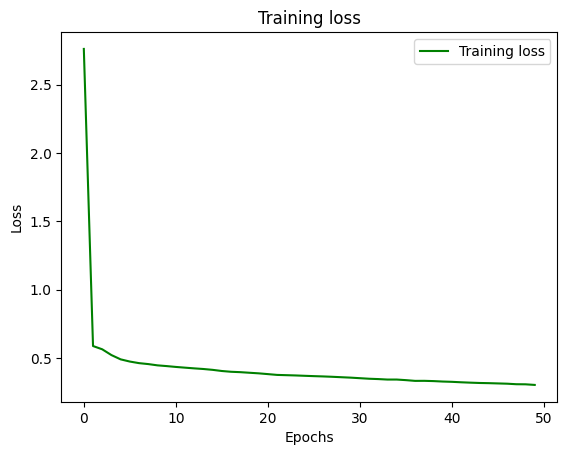

In [70]:
epochs = range(num_epochs)
plt.plot(epochs, total_train_losses, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

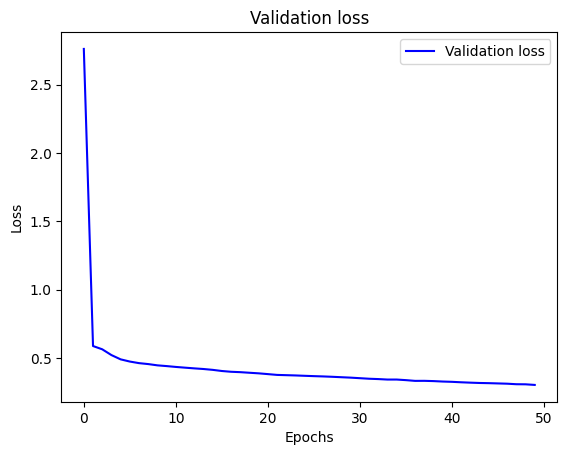

In [71]:
plt.plot(epochs, total_test_losses, 'b', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

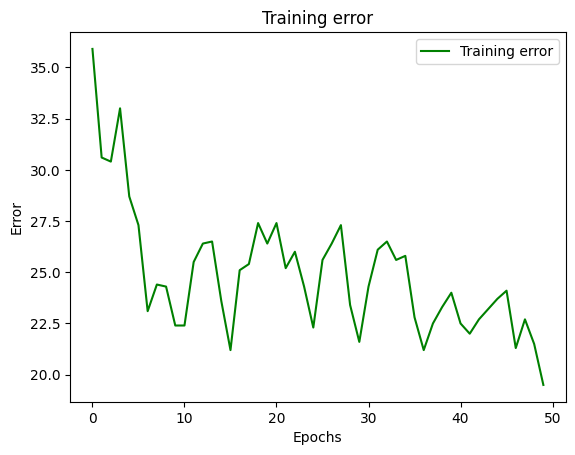

In [72]:
plt.plot(epochs, total_train_error, 'g', label='Training error')
plt.title('Training error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

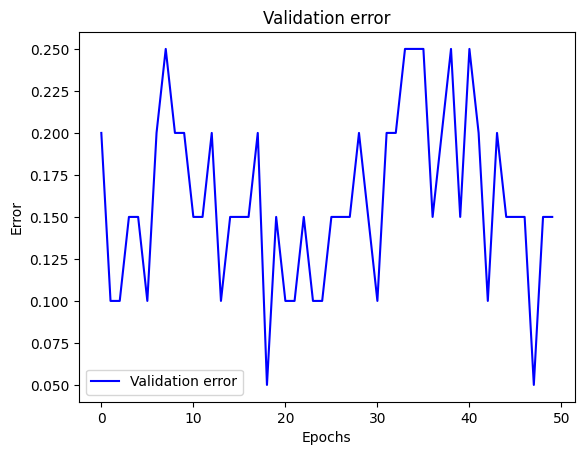

In [73]:
plt.plot(epochs, total_test_error, 'b', label='Validation error')
plt.title('Validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()